In [1]:
%matplotlib inline

In [2]:
import numpy as np

import sympy as sp

import my_orbit_lib.epoch
from my_orbit_lib.epoch import Epoch
from datetime import datetime

from my_orbit_lib.constants import *
from my_orbit_lib.extensions import *
from my_orbit_lib.body import *
from my_orbit_lib.trajectory import *

from sgp4.api import Satrec, jday, SGP4_ERRORS

import urllib.request

# Problem 4 - Numerical Verification

## Handling TLE

In [3]:
'ISS (ZARYA)'
s = '1 25544U 98067A   23067.93329804  .00008611  00000+0  16201-3 0  9994'
t = '2 25544  51.6409 105.1531 0006810  54.2527   9.8655 15.49393939386244'

In [4]:
def tle_epoch(s, t):
    y2 = int(s[18:20])
    year = y2 + (1900 if y2 >= 57 else 2000)
    fr_day = float(s[20:32])
    epoch = Epoch(Epoch(datetime(year - 1, 12, 31), utc=False).jde + fr_day)
    return epoch

In [5]:
tle_epoch(s, t).todatetime()

datetime.datetime(2023, 3, 8, 22, 23, 56, 950672)

In [6]:
class TLEElements:
    def __init__(self, s, t):
        'Following spec at https://celestrak.org/NORAD/documentation/tle-fmt.php'
        self.epoch = tle_epoch(s, t)
        self.inclination = float(t[8:16]) * np.pi / 180 
        self.raan = float(t[17:25]) * np.pi / 180 
        self.e = float('.' + t[26:33]) 
        self.argument_of_perigee = float(t[34:42]) * np.pi / 180 
        self.mean_anomaly = float(t[43:51]) * np.pi / 180
        self.mean_motion = float(t[52:63]) # mean motion, in revolutions per day
    
    def __str__(self):
        from pprint import pformat
        return pformat(vars(self), indent=4, width=1)
    
    def __repr__(self):
        return f'TLEElements({str(self)})'

In [7]:
tle = TLEElements(s, t)
tle

TLEElements({   'argument_of_perigee': 0.9468882430967276,
    'e': 0.000681,
    'epoch': Epoch(2460012.43329804),
    'inclination': 0.9013037336931398,
    'mean_anomaly': 0.1721854573555006,
    'mean_motion': 15.49393939,
    'raan': 1.8352678136788494})

## TLE to Keplerian

For simplicity sake, let's first recover the Keplerian elements without performing the deaveraging procedure.

The mean motion (which is given in revolutions per day) we should convert to radians per second, then we can recover $a$ by using the following formula ([derived using Kepler's Third Law](https://en.wikipedia.org/wiki/Mean_motion#Mean_motion_and_Kepler's_laws)):

$$n = \sqrt{\frac{\mu}{a^3}}$$

In [8]:
def get_sma(tle):
    return sp.cbrt(STANDARD_GRAVITATIONAL_PARAMETER_EARTH / (tle.mean_motion * 2 * np.pi / (86400 * second))**2)

In [9]:
a = get_sma(tle)
a - EARTH_RADIUS

425.469120606388*kilometer

We are using the ISS's TLE for the example, and this height seems right (currently).

From p. 24 of [Fundamentals of Astrodynamics by Bate et al. 2020](https://books.google.bg/books?id=UEC9DwAAQBAJ&printsec=frontcover&hl=bg&source=gbs_ge_summary_r&cad=0#v=onepage&q&f=false) we find the formula to relate eccentricy with specific angular momentum $h$:

$$e = \sqrt{1+\frac{2\epsilon h^2}{\mu^2}}$$

which together with:

$$\epsilon = -\frac{\mu}{2a}$$

we can find $h$:

In [10]:
def get_specific_energy(a):
    return -STANDARD_GRAVITATIONAL_PARAMETER_EARTH / (2 * a)

In [11]:
def get_specific_angular_momentum(tle):
    a = get_sma(tle)
    e = tle.e
    return STANDARD_GRAVITATIONAL_PARAMETER_EARTH * sp.sqrt(1/2 * (e**2 - 1) / get_specific_energy(a))

In [12]:
h = get_specific_angular_momentum(tle)
h

52046.8648489885*kilometer**2/second

So far we have:

In [13]:
tle.e, a, h, tle.inclination, tle.raan, tle.argument_of_perigee,

(0.000681,
 6796.46912060639*kilometer,
 52046.8648489885*kilometer**2/second,
 0.9013037336931398,
 1.8352678136788494,
 0.9468882430967276)

We're missing the true anomaly $\nu$ which we can find [by the eccentric anomaly](https://en.wikipedia.org/wiki/Eccentric_anomaly#From_the_true_anomaly) $E$:

$$\tan\frac{\nu}{2} = \sqrt{\frac{1+e}{1-e}}\tan\frac{E}{2}$$

And we can find $E$ by the mean anomaly $M$ (from the TLE elements) by solving Kepler's equation:

$$M = E - e\sin E$$

Implementation for Kepler's solver is doing Newton's method with a really good starting point:

In [14]:
def solve_cubic(a, c, d):
    assert(np.all(a > 0) and np.all(c > 0))
    p = c/a
    q = d/a
    k = np.sqrt(q**2/4 + p**3/27)
    return np.cbrt(-q/2 - k) + np.cbrt(-q/2 + k)
    
def machin(e, M):
    """
    Machin's starting point for Newton's method
    See johndcook.com/blog/2022/11/01/kepler-newton/
    """
    n = np.sqrt(5 + np.sqrt(16 + 9/e))
    a = n*(e*(n**2 - 1)+1)/6
    c = n*(1-e)
    d = -M
    s = solve_cubic(a, c, d)
    return n*np.arcsin(s)    
    
def solve_keplers_equation(e, M):
    assert(np.all(0 <= e) and np.all(e < 1))
    
    M = M.copy()
    while np.any(M < 0) or np.any(M >= 2*np.pi):
        M = np.mod(M, 2*np.pi)

    # Handle large angles
    mask = M >= np.pi
    M[mask] = 2*np.pi - M[mask]

    f = lambda E: E - e*np.sin(E) - M 
    E = machin(e, M)
    tolerance = 1e-10 
    
    # Vectorized Newton's method 
    while True:
        delta = f(E)/(1 - e*np.cos(E))
        E -= delta
        if np.all(np.abs(delta) < tolerance):
            break

    # Restore the old angles
    E[mask] = 2*np.pi - E[mask]
    return E

In [15]:
# Testing
np.random.seed(20221102)
N = 1_000_000
e = np.random.random(N)
M = np.random.random(N)*2*np.pi
E = solve_keplers_equation(e, M)
k = E - e*np.sin(E) - M # Difference to evaluating Kepler's equation
assert(np.all(abs(k) < 1e-10))

Putting it all together:

In [16]:
class KeplerianElements:
    def __init__(self, e, a, h, inclination, raan, argument_of_perigee, true_anomaly):
        self.e = e 
        self.a = a
        self.h = h
        self.inclination = inclination
        self.raan = raan
        self.argument_of_perigee = argument_of_perigee
        self.true_anomaly = true_anomaly

    def __str__(self):
        from pprint import pformat
        return pformat(vars(self), indent=4, width=1)
    
    def __repr__(self):
        return f'KeplerianElements({str(self)})'

In [17]:
def get_keplerian_elements_from_tle(tle):
    e = tle.e
    a = get_sma(tle)
    h = get_specific_angular_momentum(tle)

    inclination = tle.inclination
    raan = tle.raan
    argument_of_perigee = tle.argument_of_perigee

    M = tle.mean_anomaly
    E = solve_keplers_equation(np.array([e]), np.array([M]))

    sin_v = np.sin(E[0]) * np.sqrt(1 - e**2) / (1 - e * np.cos(E[0]))
    cos_v = (np.cos(E[0]) - e) / (1 - e * np.cos(E[0]))
    true_anomaly = np.arctan2(sin_v, cos_v)

    return KeplerianElements(e=e, a=a, h=h, inclination=inclination, raan=raan, argument_of_perigee=argument_of_perigee, true_anomaly=true_anomaly)

In [18]:
get_keplerian_elements_from_tle(tle)

KeplerianElements({   'a': 6796.46912060639*kilometer,
    'argument_of_perigee': 0.9468882430967276,
    'e': 0.000681,
    'h': 52046.8648489885*kilometer**2/second,
    'inclination': 0.9013037336931398,
    'raan': 1.8352678136788494,
    'true_anomaly': 0.17241901271231772})

## Plot

You know I love plotting... This is salvaging code from an earlier sandbox experimenting I did:

In [19]:
def rot_x(theta):
    'Get matrix that rotates by theta along the x axis'
    return np.array([[1,              0,               0],
                     [0,  np.cos(theta),  -np.sin(theta)],
                     [0,  np.sin(theta),   np.cos(theta)]]) 

In [20]:
def rot_z(theta):
    'Get matrix that rotates by theta along the z axis'
    return np.array([[np.cos(theta),  -np.sin(theta),   0],
                     [np.sin(theta),   np.cos(theta),   0],
                     [            0,               0,   1]])

In [21]:
def plot_orbit(keplerian_elements, sat=None, num_points=100, vel_arrow_scale=400, title='Orbit Plot', x_view_angle=-60, y_view_angle=25, scale=0.7):
    """
    Takes the position and velocity of a satellite and plots
    the elliptical orbit around Earth, determined by the orbital elements.

    num_points - precision for sampling when drawing the ellipse.
    """
    fig = plt.figure()
    plt.title(title)
    ax = fig.add_subplot(1, 1, 1, projection=Axes3D.name)
    ax.view_init(y_view_angle, x_view_angle)
    ax.set_box_aspect((1, 1, 1))
    ax.grid(False)

    # Plot satellite and velocity vector
    if sat is not None:
        pos, vel = sat
        vel = vel.copy()
        vel *= vel_arrow_scale

        sat = ax.scatter([pos[0]], [pos[1]], [pos[2]], label="Satellite")
        ax.quiver([pos[0]], [pos[1]], [pos[2]], [vel[0]], [vel[1]], [vel[2]], color=sat.get_fc())
    
    # Coordinate system arrows
    EARTH_RADIUS = 6371 # km
    r = EARTH_RADIUS * 0.8
    ax.quiver([0], [0], [0], [r], [0], [0], color='r', linewidth = 0.5)
    ax.quiver([0], [0], [0], [0], [r], [0], color='g', linewidth = 0.5)
    ax.quiver([0], [0], [0], [0], [0], [r], color='b', linewidth = 0.5)

    # Plot Earth
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)

    r = EARTH_RADIUS
    ax.plot_wireframe(x * r, y * r, z * r, color=(0.1, 0.2, 0.5, 0.2), linewidth=0.5)

    # Plot Orbit
    a = strip_units(keplerian_elements.a)
    e = keplerian_elements.e
    i = keplerian_elements.inclination
    raan = keplerian_elements.raan
    argument_of_perigee = keplerian_elements.argument_of_perigee

    f = np.linspace(0, 2 * np.pi, int(num_points))
    p_polar = (a * (1 - e ** 2)) / (1 + e * np.cos(f))
    
    p_cart = np.zeros((3, p_polar.shape[0]))
    p_cart[0, :] = p_polar * np.cos(f)
    p_cart[1, :] = p_polar * np.sin(f)
    
    U = rot_z(argument_of_perigee)
    V = rot_x(i)
    W = rot_z(raan)
    p_cart = W.dot(V.dot(U.dot(p_cart)))
    
    x, y, z = p_cart[0, :], p_cart[1, :], p_cart[2, :]
    ax.plot(x, y, z, '--', label="Orbit", color="green")

    # Rest of plot
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper left', borderaxespad=0)

    r = EARTH_RADIUS * scale
    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    ax.set_zlim(-r, r)
    
    ax.set_axis_off()
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.axis('off')

    plt.show()

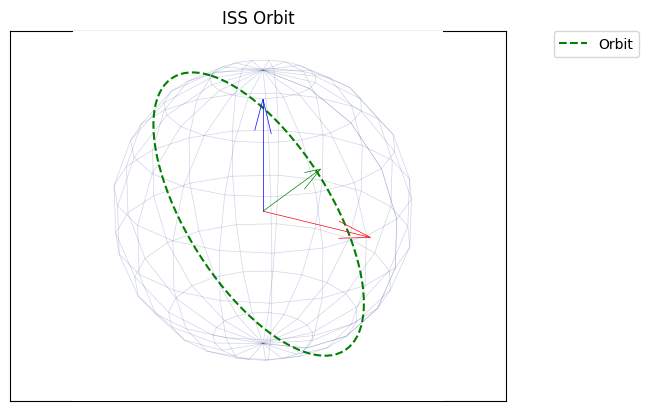

In [22]:
plot_orbit(get_keplerian_elements_from_tle(tle), title='ISS Orbit')

## Cartesian from Keplerian

https://en.wikipedia.org/wiki/Orbital_elements#Euler_angle_transformations

In [23]:
def get_cartesian_from_keplerian(keplerian_elements):
    e = keplerian_elements.e
    a = strip_units(keplerian_elements.a)

    nu = keplerian_elements.true_anomaly 
    r = a * (1 - e**2) / (1 + e * np.cos(nu))

    mu = strip_units(STANDARD_GRAVITATIONAL_PARAMETER_EARTH)

    x = r * np.array([np.cos(nu), np.sin(nu), 0])
    v = np.array([np.sqrt(mu / (a * (1 - e**2))) * (-np.sin(nu)), np.sqrt(mu / (a * (1 - e**2))) * (e + np.cos(nu)), 0])

    U = rot_z(keplerian_elements.argument_of_perigee)
    V = rot_x(keplerian_elements.inclination)
    W = rot_z(keplerian_elements.raan)

    x = W.dot(V.dot(U.dot(x)))
    v = W.dot(V.dot(U.dot(v)))

    return x, v

In [24]:
x, v = get_cartesian_from_keplerian(get_keplerian_elements_from_tle(tle))
x, v

(array([-4435.38152947,  1868.9259969 ,  4792.13289606]),
 array([-0.20093822, -7.19760652,  2.62234655]))

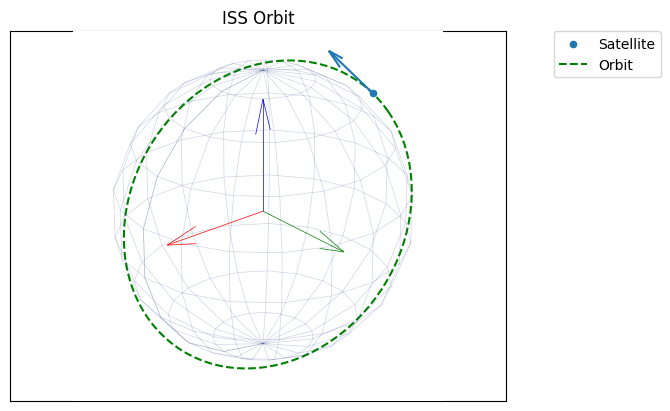

In [25]:
plot_orbit(get_keplerian_elements_from_tle(tle), sat=(x, v), title='ISS Orbit', x_view_angle=50)

In [26]:
def epoch_to_jd_fr(epoch):
    fr = epoch.jde % 0.5
    jd = epoch.jde - fr
    return jd, fr

In [27]:
iss = Satrec.twoline2rv(s, t)
jd, fr = epoch_to_jd_fr(tle.epoch)
e, x, v = iss.sgp4(jd, fr)
e

0

In [28]:
x, v

((-4432.962417408407, 1871.2826737501052, 4784.98233436862),
 (-0.20064002204535547, -7.202176023436738, 2.6253721629156197))

## What About AQUA

In [29]:
with urllib.request.urlopen('https://celestrak.org/NORAD/elements/active.txt') as response:
    lines = [line.decode().strip() for line in response]
for i, l in enumerate(lines):
    if l.startswith('AQUA'):
        break
s_aqua, t_aqua = lines[i + 1], lines[i + 2]
s_aqua, t_aqua

('1 27424U 02022A   23338.10562127  .00001725  00000+0  38031-3 0  9990',
 '2 27424  98.3074 282.1332 0001660  55.2068  72.5345 14.58632910148123')

In [30]:
aqua_tle = TLEElements(s_aqua, t_aqua)
pos_0, vel_0 = get_cartesian_from_keplerian(get_keplerian_elements_from_tle(aqua_tle))
pos_0, vel_0

(array([-1700.75235105,  4065.83568329,  5534.88298846]),
 array([-0.59828335,  5.94166872, -4.54697438]))

In [31]:
aqua_sat = Satrec.twoline2rv(s_aqua, t_aqua)
jd, fr = epoch_to_jd_fr(aqua_tle.epoch)
aqua_sat.sgp4(jd, fr)

(0,
 (-1700.8209119621708, 4069.6784702592927, 5526.16210053335),
 (-0.5986888044647186, 5.9430416305687315, -4.549249889181402))

In [32]:
DURATION = 24*3600
STEP_SIZE = 5*60

In [34]:
aqua = Body(pos=pos_0,
            vel=vel_0, 
            epoch=aqua_tle.epoch,
            name="AQUA")
tr = get_trajectory(aqua, duration=DURATION, step_size=STEP_SIZE, hmin=1e1, hmax=1e3)

In [35]:
def get_sgp4_for_duration_in_steps(s, t, duration, step_size):
    epoch = TLEElements(s, t).epoch
    aqua_sat = Satrec.twoline2rv(s, t)

    points = []
    steps = int(duration/step_size)
    for i in range(steps): 
        jd, fr = epoch_to_jd_fr(Epoch(epoch.jde + i * step_size / 86400))
        e, x, v = aqua_sat.sgp4(jd, fr)
        if e != 0:
            print(SGP4_ERRORS[e])
            return
        points.append(np.array([x, v]))
    return np.array(points)    

In [36]:
sgp4_n = get_sgp4_for_duration_in_steps(s_aqua, t_aqua, duration=DURATION, step_size=STEP_SIZE)

In [37]:
sgp4_n.shape, tr.points[:-1, :, :].shape

((288, 2, 3), (288, 2, 3))

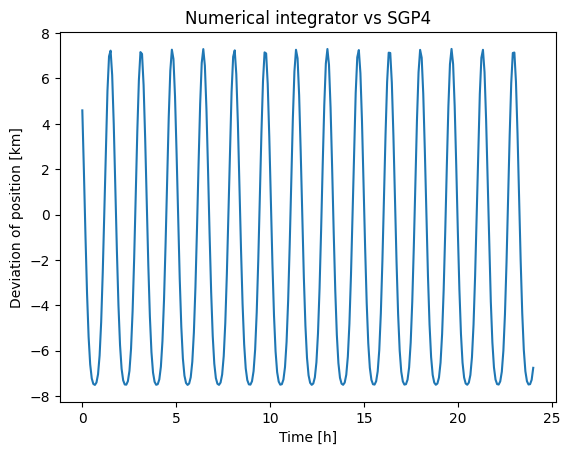

In [38]:
data = np.linalg.norm(tr.points[:-1, 0, :], axis=1) - np.linalg.norm(sgp4_n[:, 0, :], axis=1) 
x_axis = np.linspace(0, 1, len(data)) * DURATION / 3600

plt.xlabel("Time [h]")
plt.ylabel("Deviation of position [km]")
plt.title("Numerical integrator vs SGP4")

plt.plot(x_axis, data)
plt.show()